In [1]:
import numpy as np
import pandas as pd

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

/home/bruno/.virtualenvs/daily/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

### LINEAR Dataset

In [13]:
features = pd.read_pickle('features/features.pkl')

In [34]:
features = features.dropna(axis=0, how='any')

In [35]:
len(features.columns)

290

In [115]:
len(features)

7193

In [36]:
def from_ij_to_idx(i, j, n_i):
    idx = j * n_i + i
    return idx

def from_idx_to_ij(idx, n_i):
    frac = float(idx)/float(n_i)
    j = int(frac)
    i = int((frac - j) * n_i)
    return i, j

In [41]:
vartypes = ['RRLyrab', 'RRLyrc', 'Algol1', 'Algol2', 
            'CB', 'DScuti', 'LPVar', 'HBeat', 'BLHer', 
            'AnomCephei', 'Other']
types = features[['LCtype']]

In [117]:
rrlyab = features[features.LCtype==1]

In [256]:
rrlyab = features

In [257]:
len(rrlyab)

7193

In [258]:
def from_id_to_signature(starid, n_x=18, n_y=12):
    signature = np.empty((n_y, n_x))
    for x in range(n_x):
        for y in range(n_y):
            signature[y, x] = features.iloc[starid]['Signature_x_{}_y_{}'.format(x, y)]
    return signature

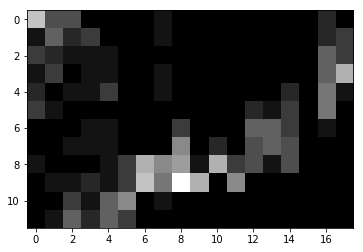

In [259]:
lc0 = from_id_to_signature(7)
plt.imshow(lc0)
plt.show()

In [260]:
cols = rrlyab.columns[rrlyab.columns.str.startswith('Signature')]

In [261]:
Xset = rrlyab[cols]

In [262]:
def from_row_to_sign(tablerow, n_x=18, n_y=12):
    signature = np.empty((n_y, n_x))
    for x in range(n_x):
        for y in range(n_y):
            signature[y, x] = tablerow['Signature_x_{}_y_{}'.format(x, y)]
    return signature

In [263]:
data = np.empty((len(Xset), 216))

for i in range(len(Xset)):
    sign = from_row_to_sign(Xset.iloc[i])
    sign = sign.reshape(216)
    data[i, :] = sign

newX = pd.DataFrame(data)

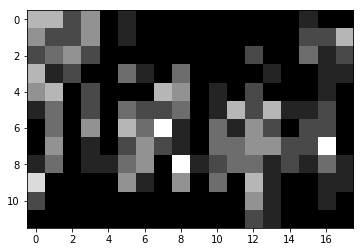

In [264]:
plt.imshow(from_row_to_sign(Xset.iloc[12]))
#.as_matrix().reshape(18, 12).T)
plt.show()

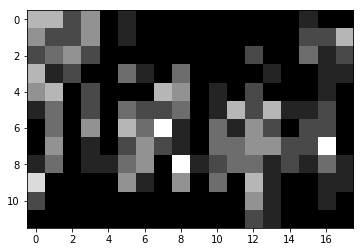

In [265]:
plt.imshow(newX.iloc[12].as_matrix().reshape(12, 18))
plt.show()

In [266]:
from sklearn.model_selection import train_test_split

In [267]:
X_train, X_test = train_test_split(newX, test_size=0.10, random_state=42)

In [268]:
X_train = X_train.as_matrix() 

In [269]:
X_test = X_test.as_matrix()

In [299]:
## this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(216,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(216, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [300]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [301]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [302]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [303]:
autoencoder.fit(X_train, X_train,
                epochs=80,
                batch_size=80,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 6473 samples, validate on 720 samples
Epoch 1/80
6473/6473 [==============================] - 1s 85us/step - loss: 0.6253 - val_loss: 0.5392
Epoch 2/80
6473/6473 [==============================] - 0s 30us/step - loss: 0.4503 - val_loss: 0.3690
Epoch 3/80
6473/6473 [==============================] - 0s 27us/step - loss: 0.2929 - val_loss: 0.2225
Epoch 4/80
6473/6473 [==============================] - 0s 29us/step - loss: 0.1731 - val_loss: 0.1275
Epoch 5/80
6473/6473 [==============================] - 0s 36us/step - loss: 0.0906 - val_loss: 0.0584
Epoch 6/80
6473/6473 [==============================] - 0s 36us/step - loss: 0.0263 - val_loss: 0.0027
Epoch 7/80
6473/6473 [==============================] - 0s 33us/step - loss: -0.0276 - val_loss: -0.0436
Epoch 8/80
6473/6473 [==============================] - 0s 29us/step - loss: -0.0730 - val_loss: -0.0822
Epoch 9/80
6473/6473 [==============================] - 0s 28us/step - loss: -0.1120 - val_loss: -0.1151
Epoch 10/80
6473/647

In [304]:
# encode and decode some lightcurves
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

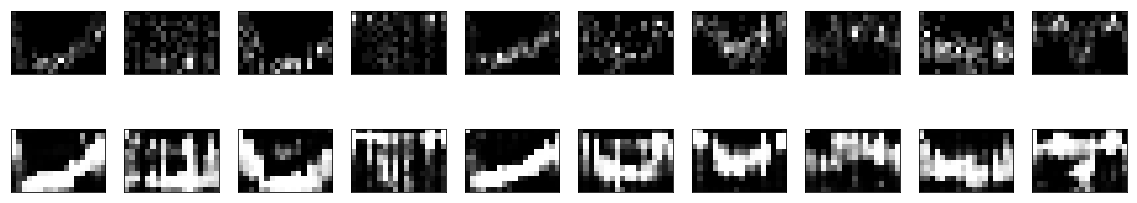

In [305]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(12, 18))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(12, 18))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

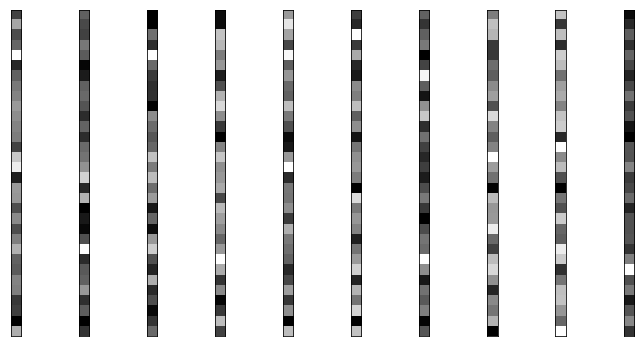

In [307]:
plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(32, 1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()